In [1]:
from pytorch_model import load_wpod
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms, utils, models
from torch import nn
import torch
from src.label import Label, Shape
from src.utils import getWH, nms, im2single, IOU_centre_and_dims
from src.projection_utils import getRectPts, find_T_matrix
import time
from utils import *
from tqdm import tqdm
from torchviz import make_dot, make_dot_from_trace

In [5]:
pil_to_tensor = transforms.ToTensor()
tensor_to_pil = transforms.ToPILImage()

In [71]:
class DLabel (Label):

    def __init__(self,cl,pts,prob):
        self.pts = pts
        tl = np.amin(pts,1)
        br = np.amax(pts,1)
        Label.__init__(self,cl,tl,br,prob)


def reconstruct(Iorig,I,Y,out_size,threshold=.9):

    net_stride 	= 2**4
    side = ((208. + 40.)/2.)/net_stride # 7.75
    
    Probs = Y[...,0]
    Affines = Y[...,2:]
    rx,ry = Y.shape[:2]
    ywh = Y.shape[1::-1]
    iwh = np.array(I.shape[1::-1],dtype=float).reshape((2,1))
    xx,yy = np.where(Probs>threshold)
    
    WH = getWH(I.shape)
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha

    base = lambda vx,vy: np.matrix([[-vx,-vy,1.],[vx,-vy,1.],[vx,vy,1.],[-vx,vy,1.]]).T
    labels = []

    for i in range(len(xx)):
        y,x = xx[i],yy[i]
        affine = Affines[y,x]
        prob = Probs[y,x]
        mn = np.array([float(x) + .5,float(y) + .5])
        A = np.reshape(affine,(2,3))
        A[0,0] = max(A[0,0],0.)
        A[1,1] = max(A[1,1],0.)
        pts = np.array(A*base(vxx,vyy)) #*alpha
        pts_MN_center_mn = pts*side
        pts_MN = pts_MN_center_mn + mn.reshape((2,1))

        pts_prop = pts_MN/MN.reshape((2,1))

        labels.append(DLabel(0,pts_prop,prob))

    final_labels = nms(labels,.1)
    TLps = []

    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for i,label in enumerate(final_labels):

            t_ptsh 	= getRectPts(0,0,out_size[0],out_size[1])
            ptsh 	= np.concatenate((label.pts*getWH(Iorig.shape).reshape((2,1)),np.ones((1,4))))
            H 		= find_T_matrix(ptsh,t_ptsh)
            Ilp 	= cv2.warpPerspective(Iorig,H,out_size,borderValue=.0)

            TLps.append(Ilp)

    return final_labels,TLps
    

def detect_lp(model,I,max_dim,net_step,out_size,threshold,masked_pattern=None,train=None):

    min_dim_img = min(I.shape[:2])
    factor 		= float(max_dim)/min_dim_img

    w,h = (np.array(I.shape[1::-1],dtype=float)*factor).astype(int).tolist()
    w += (w%net_step!=0)*(net_step - w%net_step)
    h += (h%net_step!=0)*(net_step - h%net_step)
    Iresized = cv2.resize(I,(w,h))

    Tn = Iresized.copy()
    Tn = Tn.reshape((1,Tn.shape[0],Tn.shape[1],Tn.shape[2]))
    Tn = torch.tensor(Tn, device=device).permute(0,3,1,2)
    start = time.time()
    model.eval()
    if masked_pattern is not None:
        Tn = Tn*masked_pattern
    if train:
        Yr = model(Tn).permute(0,2,3,1)
        Yr = np.squeeze(Yr)
        return None,None,None,Yr,Tn
    else:
        Yr = model(Tn).permute(0,2,3,1).cpu().detach().numpy()
    Yr = np.squeeze(Yr)
    elapsed = time.time() - start
    
    L,TLps = reconstruct(I,Iresized,Yr,out_size,threshold)

    return L,TLps,elapsed,Yr,Tn


In [7]:
def labels2output_map(label,lppts,dim,stride):

	side = ((float(dim) + 40.)/2.)/stride # 7.75 when dim = 208 and stride = 16

	outsize = int(dim/stride)
	Y  = np.zeros((outsize,outsize,2*4+1),dtype='float32')
	MN = np.array([outsize,outsize])
	WH = np.array([dim,dim],dtype=float)

	tlx,tly = np.floor(np.maximum(label.tl(),0.)*MN).astype(int).tolist()
	brx,bry = np.ceil (np.minimum(label.br(),1.)*MN).astype(int).tolist()

	for x in range(tlx,brx):
		for y in range(tly,bry):

			mn = np.array([float(x) + .5, float(y) + .5])
			iou = IOU_centre_and_dims(mn/MN,label.wh(),label.cc(),label.wh())

			if iou > .5:

				p_WH = lppts*WH.reshape((2,1))
				p_MN = p_WH/stride

				p_MN_center_mn = p_MN - mn.reshape((2,1))

				p_side = p_MN_center_mn/side

				Y[y,x,0] = 1.
				Y[y,x,1:] = p_side.T.flatten()

	return Y

Searching for license plates using WPOD-NET
(208, 208, 3)
		Bound dim: 288, ratio: 1.000000
found


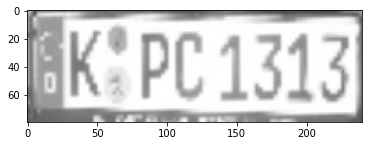

In [8]:
def adjust_pts(pts,lroi):
	return pts*lroi.wh().reshape((2,1)) + lroi.tl().reshape((2,1))


output_dir = "./temp"

lp_threshold = .5

wpod_net = load_wpod()
wpod_net.to(device)
wpod_net.eval()
print('Searching for license plates using WPOD-NET')

Ivehicle = cv2.imread('Plate_examples/germany_car_plate.jpg')
Ivehicle = cv2.resize(Ivehicle,(208,208))
#Ivehicle = Ivehicle[450:630, 480:1170]
plt.imshow(Ivehicle)
print(Ivehicle.shape)
#Ivehicle = cv2.bitwise_and(Ivehicle, Ivehicle, mask=cv2.bitwise_not(get_mask(Ivehicle)))
ratio = float(max(Ivehicle.shape[:2]))/min(Ivehicle.shape[:2])
side  = int(ratio*288.)
bound_dim = min(side + (side%(2**4)),608)
print("\t\tBound dim: %d, ratio: %f" % (bound_dim,ratio)) 

Llp,LlpImgs,_,Yr,_ = detect_lp(wpod_net,im2single(Ivehicle),bound_dim,2**4,(240,80),lp_threshold)

if len(LlpImgs):
    print('found')
    Ilp = LlpImgs[0]
    Ilp = cv2.cvtColor(Ilp, cv2.COLOR_BGR2GRAY)
    Ilp = cv2.cvtColor(Ilp, cv2.COLOR_GRAY2BGR)

    s = Shape(Llp[0].pts)

    plt.imshow(Ilp)


In [9]:
tl,br = s.pts.min(1),s.pts.max(1)
llp = Label(0,tl,br)
Y = labels2output_map(llp,s.pts,288,16)

In [10]:
Ivehicle.shape

(208, 208, 3)

In [11]:
np.where(Yr[...,1]<0.1)

(array([7, 8, 8, 8]), array([ 9,  8,  9, 10]))

(288, 288)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

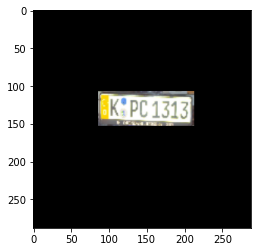

In [93]:
def get_mask(Ivehicle,h=None,w=None,d=None):
    if h:
        height,width,depth = h,w,d
    else: height,width,depth = Ivehicle.shape
    x = Ivehicle.copy()
    x = cv2.resize(x,(height,width))
    circle_img = np.zeros((height,width), np.uint8)
    cv2.rectangle(circle_img,(86,107),(212,152),280,thickness=-1)
    print(circle_img.shape)
    #circle_img = circle_img.reshape((1,circle_img.shape[0],circle_img.shape[1]))
    #circle_img = torch.tensor(circle_img).permute(0,1,2)
    #cv2.rectangle(circle_img,(480,480),(1170,570),255,thickness=-1)
    plt.imshow(cv2.bitwise_and(x, x, mask=circle_img))
    return circle_img
get_mask(Ivehicle,288,288,3)

In [20]:
account_resize = True
repeat_size=1

#For resize post convolution
if account_resize:
    repeat_size = int(3024/3024)
    img = Ivehicle.resize((208,208))
    model_img_size = img.size[0]
    img_t = pil_to_tensor(img)
    img_t = img_t.to(device)
    def resize2d(img, size):
        return (F.adaptive_avg_pool2d(Variable(img), size)).data
    def upsample2d(img, size=224):
        upsample = nn.Upsample(size=size, mode='bilinear', align_corners=False)
        return upsample(torch.unsqueeze(img, 0))[0]
else:
    model_img_size = 224

In [21]:
model_img_size = 288

In [22]:
# typical exposure is in form 1/n s. Available: 15, 20, 25 30, 40, 50, 60, 80, 100, 125, 160, 200, 250
exposure = 125 
exp_micros = 1000000/exposure          # get exposure in microseconds
img_ratio = 3024 / model_img_size      # every row in model is img_ratio rows in original image
model_tr = 10 * img_ratio              # multiply real tr (10 micros) by img_ratio to find model tr
conv_size = exp_micros / model_tr      # divide exposure time by tr to find convolution size
conv_size = int(conv_size)             # Need closest integer approximation. Won't cause a significant difference
conv_size

76

In [23]:
Ivehicle = cv2.imread('Plate_examples/germany_car_plate.jpg')
Ivehicle = cv2.resize(Ivehicle,(208,208))

(288, 288)


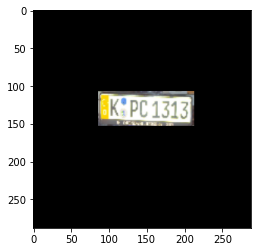

In [202]:
sz = model_img_size + conv_size - 1 # 300   #Length of input signal
c = 0    #Ambient light ratio
c_limits = [0,0]
batch = 1
channels = 3
# change of variable term to optimise on
w = torch.ones([channels,sz,1], requires_grad=True, dtype=torch.float, device=device)

#Create the mask to only illuminate the object
#mask = torch.tensor(get_mask(Ivehicle,288,288,3), dtype=torch.float, device=device)
mask = torch.tensor(get_mask(Ivehicle,288,288,3), device=device)
mask = mask / torch.max(mask)
#mask = get_mask(Ivehicle,288,288,3)

#Target and original class labels
#orig = torch.tensor([classidx], dtype=torch.long, device=device)

#Model parameters
lr = 1e-1
n_epochs = 5000
optimizer = optim.Adam([w], lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [203]:
labelf = torch.flatten(torch.tensor(Y[...,0], dtype=torch.float, device=device))
labelnf = torch.flatten(torch.tensor(1-Y[...,0], dtype=torch.float, device=device))
def logloss(ptrue, pred, eps=10e-10):
    Pred = torch.clamp(pred,eps,1.)
    Pred = -torch.log(Pred)
    Pred = torch.dot(Pred,ptrue)
    #Pred = torch.reshape(Pred,(b,h*w*ch))
    #Pred = torch.sum(Pred,1)
    return Pred

In [204]:
#Track the loss to target and original class
targloss = []
origloss = []

#obj_dict = {}
#w = -1*w
#Optimisation loop. initially untargeted
for epoch in tqdm(range(n_epochs)):
    
    if channels==1:
        n_w = w.repeat(3,1,1)
    else:
        n_w = w
    
    # For resize post convolution
    if account_resize:
        n_w = torch.repeat_interleave(n_w, repeats=repeat_size, dim=1)
    
    sig_height = model_img_size + conv_size - 1
    gy, new_w = fttogy(n_w, batch, None, c_limits, sig_height, conv_size, 0)
    gy = 1-mask + torch.mul(gy,mask)
    #with torch.autograd.set_detect_anomaly(True):
    Llp,LlpImgs,x,Yr,T = detect_lp(wpod_net,im2single(Ivehicle),bound_dim,2**4,(240,80),lp_threshold,gy,train=True)
    
    outf = torch.flatten(Yr[:,:,0])
    outnf = torch.flatten(Yr[:,:,1])
    
    loss = -1*logloss(labelf,outf)
    
    if epoch%100==0:
        print(-1*loss)
   
    loss.backward()   
    
    if epoch%10==0:
        optimizer.step()
        optimizer.zero_grad()
        del loss
        torch.cuda.empty_cache()
    #if epoch!=n_epochs-1:
    #    del inp
    #    del new_w
    #else:
        #saving w to be used for prediction
        #torch.save(n_w,'w_0.5_764.pt')

    #Code to check gpu allocation    
    '''
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                #print(type(obj), obj.size())
                if type(obj) not in obj_dict:
                    obj_dict[type(obj)] = 1
                else:
                    obj_dict[type(obj)] += 1
        except: pass
    print(obj_dict)
    obj_dict.clear()
    '''


  0%|          | 0/5000 [00:00<?, ?it/s]

tensor(4.1493, device='cuda:0', grad_fn=<MulBackward0>)


  2%|▏         | 105/5000 [00:03<02:21, 34.49it/s]

tensor(4.9057, device='cuda:0', grad_fn=<MulBackward0>)


  4%|▍         | 205/5000 [00:06<02:21, 33.95it/s]

tensor(6.2136, device='cuda:0', grad_fn=<MulBackward0>)


  6%|▌         | 305/5000 [00:09<02:15, 34.70it/s]

tensor(6.3549, device='cuda:0', grad_fn=<MulBackward0>)


  8%|▊         | 405/5000 [00:12<02:13, 34.52it/s]

tensor(6.4024, device='cuda:0', grad_fn=<MulBackward0>)


 10%|█         | 505/5000 [00:15<02:10, 34.46it/s]

tensor(6.5025, device='cuda:0', grad_fn=<MulBackward0>)


 12%|█▏        | 605/5000 [00:18<02:07, 34.50it/s]

tensor(6.5156, device='cuda:0', grad_fn=<MulBackward0>)


 14%|█▍        | 705/5000 [00:21<02:05, 34.24it/s]

tensor(6.5103, device='cuda:0', grad_fn=<MulBackward0>)


 16%|█▌        | 805/5000 [00:24<02:02, 34.12it/s]

tensor(6.5276, device='cuda:0', grad_fn=<MulBackward0>)


 18%|█▊        | 905/5000 [00:26<01:59, 34.35it/s]

tensor(6.5329, device='cuda:0', grad_fn=<MulBackward0>)


 20%|██        | 1005/5000 [00:29<01:55, 34.57it/s]

tensor(6.5075, device='cuda:0', grad_fn=<MulBackward0>)


 22%|██▏       | 1105/5000 [00:32<01:53, 34.22it/s]

tensor(6.4847, device='cuda:0', grad_fn=<MulBackward0>)


 24%|██▍       | 1205/5000 [00:35<01:50, 34.23it/s]

tensor(6.5395, device='cuda:0', grad_fn=<MulBackward0>)


 26%|██▌       | 1305/5000 [00:38<01:46, 34.61it/s]

tensor(6.5095, device='cuda:0', grad_fn=<MulBackward0>)


 28%|██▊       | 1405/5000 [00:41<01:44, 34.25it/s]

tensor(6.5061, device='cuda:0', grad_fn=<MulBackward0>)


 30%|███       | 1505/5000 [00:44<01:45, 33.23it/s]

tensor(6.5381, device='cuda:0', grad_fn=<MulBackward0>)


 32%|███▏      | 1605/5000 [00:47<01:38, 34.44it/s]

tensor(6.5497, device='cuda:0', grad_fn=<MulBackward0>)


 34%|███▍      | 1705/5000 [00:50<01:35, 34.44it/s]

tensor(6.4960, device='cuda:0', grad_fn=<MulBackward0>)


 36%|███▌      | 1805/5000 [00:53<01:32, 34.53it/s]

tensor(6.5253, device='cuda:0', grad_fn=<MulBackward0>)


 38%|███▊      | 1905/5000 [00:55<01:30, 34.25it/s]

tensor(6.5045, device='cuda:0', grad_fn=<MulBackward0>)


 40%|████      | 2005/5000 [00:58<01:26, 34.48it/s]

tensor(6.4677, device='cuda:0', grad_fn=<MulBackward0>)


 42%|████▏     | 2105/5000 [01:01<01:23, 34.48it/s]

tensor(6.5431, device='cuda:0', grad_fn=<MulBackward0>)


 44%|████▍     | 2205/5000 [01:04<01:21, 34.23it/s]

tensor(6.5336, device='cuda:0', grad_fn=<MulBackward0>)


 46%|████▌     | 2305/5000 [01:07<01:17, 34.67it/s]

tensor(6.5287, device='cuda:0', grad_fn=<MulBackward0>)


 48%|████▊     | 2405/5000 [01:10<01:15, 34.43it/s]

tensor(6.5324, device='cuda:0', grad_fn=<MulBackward0>)


 50%|█████     | 2505/5000 [01:13<01:13, 34.13it/s]

tensor(6.5403, device='cuda:0', grad_fn=<MulBackward0>)


 52%|█████▏    | 2605/5000 [01:16<01:09, 34.62it/s]

tensor(6.5307, device='cuda:0', grad_fn=<MulBackward0>)


 54%|█████▍    | 2705/5000 [01:19<01:06, 34.37it/s]

tensor(6.4643, device='cuda:0', grad_fn=<MulBackward0>)


 56%|█████▌    | 2805/5000 [01:22<01:03, 34.48it/s]

tensor(6.6023, device='cuda:0', grad_fn=<MulBackward0>)


 58%|█████▊    | 2905/5000 [01:24<01:00, 34.46it/s]

tensor(6.5380, device='cuda:0', grad_fn=<MulBackward0>)


 60%|██████    | 3005/5000 [01:27<00:57, 34.52it/s]

tensor(6.5248, device='cuda:0', grad_fn=<MulBackward0>)


 62%|██████▏   | 3105/5000 [01:30<00:54, 34.56it/s]

tensor(6.5478, device='cuda:0', grad_fn=<MulBackward0>)


 64%|██████▍   | 3205/5000 [01:33<00:51, 34.55it/s]

tensor(6.6235, device='cuda:0', grad_fn=<MulBackward0>)


 66%|██████▌   | 3305/5000 [01:36<00:49, 34.51it/s]

tensor(6.4219, device='cuda:0', grad_fn=<MulBackward0>)


 68%|██████▊   | 3405/5000 [01:39<00:46, 34.27it/s]

tensor(6.4934, device='cuda:0', grad_fn=<MulBackward0>)


 70%|███████   | 3505/5000 [01:42<00:43, 34.55it/s]

tensor(6.5662, device='cuda:0', grad_fn=<MulBackward0>)


 72%|███████▏  | 3605/5000 [01:45<00:40, 34.52it/s]

tensor(6.5347, device='cuda:0', grad_fn=<MulBackward0>)


 74%|███████▍  | 3705/5000 [01:48<00:37, 34.62it/s]

tensor(6.4990, device='cuda:0', grad_fn=<MulBackward0>)


 76%|███████▌  | 3805/5000 [01:50<00:34, 34.60it/s]

tensor(6.5045, device='cuda:0', grad_fn=<MulBackward0>)


 78%|███████▊  | 3905/5000 [01:53<00:31, 34.48it/s]

tensor(6.5898, device='cuda:0', grad_fn=<MulBackward0>)


 80%|████████  | 4005/5000 [01:56<00:28, 34.78it/s]

tensor(6.5019, device='cuda:0', grad_fn=<MulBackward0>)


 82%|████████▏ | 4105/5000 [01:59<00:25, 34.52it/s]

tensor(6.5424, device='cuda:0', grad_fn=<MulBackward0>)


 84%|████████▍ | 4205/5000 [02:02<00:22, 34.68it/s]

tensor(6.4828, device='cuda:0', grad_fn=<MulBackward0>)


 86%|████████▌ | 4305/5000 [02:05<00:20, 34.52it/s]

tensor(6.4937, device='cuda:0', grad_fn=<MulBackward0>)


 88%|████████▊ | 4405/5000 [02:08<00:17, 34.46it/s]

tensor(6.4999, device='cuda:0', grad_fn=<MulBackward0>)


 90%|█████████ | 4505/5000 [02:11<00:14, 34.73it/s]

tensor(6.5246, device='cuda:0', grad_fn=<MulBackward0>)


 92%|█████████▏| 4605/5000 [02:14<00:11, 34.29it/s]

tensor(6.5573, device='cuda:0', grad_fn=<MulBackward0>)


 94%|█████████▍| 4705/5000 [02:17<00:08, 34.51it/s]

tensor(6.4761, device='cuda:0', grad_fn=<MulBackward0>)


 96%|█████████▌| 4805/5000 [02:19<00:05, 34.81it/s]

tensor(6.5256, device='cuda:0', grad_fn=<MulBackward0>)


 98%|█████████▊| 4905/5000 [02:22<00:02, 34.49it/s]

tensor(6.4914, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 5000/5000 [02:25<00:00, 34.36it/s]


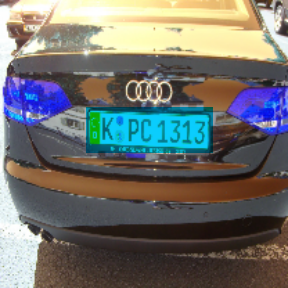

In [194]:
tensor_to_pil(T[0].cpu())

In [195]:
Yr[:,:,0][np.where(Yr[:,:,0].cpu()>0.5)]

tensor([0.8022, 0.9925, 0.9995, 0.9995, 0.9987], device='cuda:0',
       grad_fn=<IndexBackward>)

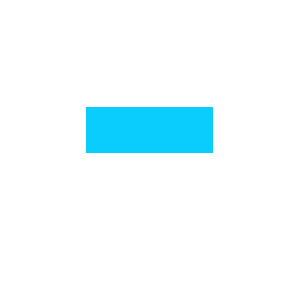

In [196]:
display(tensor_to_pil(gy[0].cpu()))